In [1]:
! export PYTHONPATH="$PYTHONPATH:$HOME/generic_implementation/POISEVAE"

In [2]:
import glob 

import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F  # activation function
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

from joint_dataset import MNIST_SVHN
from POISEVAE import POISEVAE # Remember to do export PYTHONPATH ...
from POISEVAE import util

In [3]:
class EncMNIST(nn.Module):
    def __init__(self, latent_dim):
        super(EncMNIST, self).__init__()
        self.latent_dim = latent_dim
        self.dim_MNIST = 28 * 28

        self.enc1 = nn.Linear(self.dim_MNIST, 400)
        self.enc_mu = nn.Linear(400, latent_dim)
        self.enc_var = nn.Linear(400, latent_dim)

    def forward(self, x):
        x = F.relu(self.enc1(x))
        mu = self.enc_mu(x)
        log_var = self.enc_var(x)
        return mu, log_var

class DecMNIST(nn.Module):
    def __init__(self, latent_dim):
        super(DecMNIST, self).__init__()  
        self.latent_dim = latent_dim
        self.dim_MNIST   = 28 * 28
        
        self.dec = nn.Sequential(nn.Linear(self.latent_dim, 400), 
                                 nn.ReLU(inplace=True), 
                                 nn.Linear(400, self.dim_MNIST))
        
    def forward(self, x):
        return self.dec(x)

In [4]:
class EncSVHN(nn.Module):
    def __init__(self, latent_dim):
        super(EncSVHN, self).__init__()
        self.latent_dim = latent_dim
        
        n_channels = (3, 32, 64, 128)
        kernels = (4, 4, 4)
        strides = (2, 2, 2)
        paddings = (1, 1, 1)
        li = []
        for i, (n, k, s, p) in enumerate(zip(n_channels[1:], kernels, strides, paddings), 1):
            li += [nn.Conv2d(n_channels[i-1], n, kernel_size=k, stride=s, padding=p), 
                   nn.ReLU(inplace=True)]
            
        self.enc = nn.Sequential(*li)
        self.enc_mu = nn.Conv2d(in_channels=128, out_channels=latent_dim, 
                                kernel_size=4, stride=1, padding=0)
        self.enc_var = nn.Conv2d(in_channels=128, out_channels=latent_dim, 
                                 kernel_size=4, stride=1, padding=0)
        
    def forward(self, x):
        x = self.enc(x)
        # Be careful not to squeeze the batch dimension if batch size = 1
        mu = self.enc_mu(x).squeeze(3).squeeze(2)
        log_var = self.enc_var(x).squeeze(3).squeeze(2)
        return mu, log_var
    
class DecSVHN(nn.Module):
    def __init__(self, latent_dim):
        super(DecSVHN, self).__init__()  
        self.latent_dim = latent_dim
        
        n_channels = (latent_dim, 128, 64, 32, 3)
        kernels = (4, 4, 4, 4)
        strides = (1, 2, 2, 2)
        paddings = (0, 1, 1, 1)
        li = []
        for i, (n, k, s, p) in enumerate(zip(n_channels[1:], kernels, strides, paddings), 1):
            li += [nn.ConvTranspose2d(n_channels[i-1], n, kernel_size=k, stride=s, padding=p), 
                   nn.ReLU(inplace=True)]
        li[-1] = nn.Sigmoid()
        
        self.dec = nn.Sequential(*li)
        
    def forward(self, x):
        x = self.dec(x)
        return x

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
MNIST_PATH = 'MNIST/MNIST/processed/%s.pt'
SVHN_PATH = 'SVHN/%s_32x32.mat'

joint_dataset_train = MNIST_SVHN(mnist_pt_path=MNIST_PATH % 'train', svhn_mat_path=SVHN_PATH % 'train')
joint_dataset_test = MNIST_SVHN(mnist_pt_path=MNIST_PATH % 'train', svhn_mat_path=SVHN_PATH % 'test')

In [7]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(joint_dataset_train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(joint_dataset_test, batch_size=batch_size, shuffle=True)
len(train_loader), len(test_loader)

(938, 938)

In [8]:
enc_mnist = EncMNIST(32).to(device)
dec_mnist = DecMNIST(32).to(device)
enc_svhn = EncSVHN(16).to(device)
dec_svhn = DecSVHN(16).to(device)

def MSELoss(input, target):
    loss = nn.functional.mse_loss(input, target, reduction='sum') #/ batch_size
    return loss
    
def MAELoss(input, target):
    loss = nn.functional.l1_loss(input, target, reduction='sum') #/ batch_size
    return loss
    
vae = POISEVAE([enc_mnist, enc_svhn], [dec_mnist, dec_svhn], [MSELoss, MSELoss], 
               latent_dims=[32, (16, 1, 1)]).to(device)

In [9]:
# for i in vae.named_parameters():
#     print(i[0])

In [10]:
optimizer = optim.Adam(vae.parameters(), lr=3e-4)

In [11]:
PATH = 'MNIST_SVHN_training_tentative/'

In [12]:
epoch = 0
# try:
#     vae, optimizer, epoch = load_checkpoint(vae, optimizer, sorted(glob.glob(PATH + 'train*.pt'))[-1])
# except:
#     pass

In [13]:
train_loss = []
test_loss = []
epochs = 20 + epoch
for epoch in range(epoch, epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_losses = util.train(vae, train_loader, optimizer, epoch, progress_bar=True)
    train_loss.append(train_epoch_losses)
    ret = util.test(vae, test_loader, epoch, record_idx=(2, 3), return_latents=True)
    test_epoch_losses, labels, latent_info = ret[:4], ret[-2], ret[-1]
    test_loss.append(test_epoch_losses)
    print(f"Train Loss: %.4f\n\tRec: %.4f, %.4f\n\tKLD Loss %.4f" % train_epoch_losses)
    print(f"Test Loss: %.4f\n\tRec: %.4f, %.4f\n\tKLD Loss %.4f" % test_epoch_losses)
    if (epoch+1) % 10 == 0 and epoch > 0:
        util.save_checkpoint(vae, optimizer, PATH + 'training_%d.pt' % epoch, epoch)
train_loss = np.array(train_loss).T
test_loss = np.array(test_loss).T

Epoch 1 of 20


100%|█████████████████████████████████████████| 938/938 [00:22<00:00, 41.27it/s]


Train Loss: 105.0452
	Rec: 43.0879, 63.4945
	KLD Loss -1.5372
Test Loss: 83.3764
	Rec: 36.8496, 48.1841
	KLD Loss -1.6573
Epoch 2 of 20


100%|█████████████████████████████████████████| 938/938 [00:23<00:00, 39.67it/s]


Train Loss: 75.3063
	Rec: 33.8593, 41.4027
	KLD Loss 0.0443
Test Loss: 73.9458
	Rec: 33.0730, 41.1141
	KLD Loss -0.2413
Epoch 3 of 20


100%|█████████████████████████████████████████| 938/938 [00:23<00:00, 39.54it/s]


Train Loss: 68.1419
	Rec: 30.9494, 36.2713
	KLD Loss 0.9211
Test Loss: 68.1039
	Rec: 29.7549, 37.7477
	KLD Loss 0.6012
Epoch 4 of 20


100%|█████████████████████████████████████████| 938/938 [00:23<00:00, 40.04it/s]


Train Loss: 62.8916
	Rec: 28.8767, 33.0601
	KLD Loss 0.9549
Test Loss: 63.8258
	Rec: 29.2353, 33.7930
	KLD Loss 0.7975
Epoch 5 of 20


100%|█████████████████████████████████████████| 938/938 [00:23<00:00, 40.30it/s]


Train Loss: 59.1825
	Rec: 27.3868, 30.8098
	KLD Loss 0.9860
Test Loss: 61.0065
	Rec: 27.2157, 33.2320
	KLD Loss 0.5588
Epoch 6 of 20


100%|█████████████████████████████████████████| 938/938 [00:22<00:00, 40.91it/s]


Train Loss: 56.9371
	Rec: 26.2623, 29.8685
	KLD Loss 0.8062
Test Loss: 58.6047
	Rec: 26.2933, 31.1448
	KLD Loss 1.1666
Epoch 7 of 20


100%|█████████████████████████████████████████| 938/938 [00:23<00:00, 40.57it/s]


Train Loss: 55.3610
	Rec: 25.4316, 29.1835
	KLD Loss 0.7460
Test Loss: 56.2892
	Rec: 25.2994, 30.1125
	KLD Loss 0.8773
Epoch 8 of 20


100%|█████████████████████████████████████████| 938/938 [00:23<00:00, 40.61it/s]


Train Loss: 53.6772
	Rec: 24.7701, 28.2329
	KLD Loss 0.6742
Test Loss: 59.2175
	Rec: 24.8105, 33.5095
	KLD Loss 0.8974
Epoch 9 of 20


100%|█████████████████████████████████████████| 938/938 [00:23<00:00, 40.64it/s]


Train Loss: 52.5208
	Rec: 24.2382, 27.6583
	KLD Loss 0.6243
Test Loss: 54.2448
	Rec: 24.3004, 29.2211
	KLD Loss 0.7233
Epoch 10 of 20


100%|█████████████████████████████████████████| 938/938 [00:23<00:00, 40.33it/s]


Train Loss: 51.7661
	Rec: 23.8157, 27.3461
	KLD Loss 0.6043
Test Loss: 52.4685
	Rec: 23.5648, 28.5982
	KLD Loss 0.3054
Epoch 11 of 20


100%|█████████████████████████████████████████| 938/938 [00:23<00:00, 40.59it/s]


Train Loss: 50.9982
	Rec: 23.3901, 27.0163
	KLD Loss 0.5919
Test Loss: 52.0625
	Rec: 23.4449, 28.2970
	KLD Loss 0.3207
Epoch 12 of 20


100%|█████████████████████████████████████████| 938/938 [00:23<00:00, 39.88it/s]


Train Loss: 50.0061
	Rec: 23.0649, 26.4425
	KLD Loss 0.4986
Test Loss: 50.8246
	Rec: 23.0430, 27.7844
	KLD Loss -0.0028
Epoch 13 of 20


100%|█████████████████████████████████████████| 938/938 [00:25<00:00, 37.21it/s]


Train Loss: 49.6328
	Rec: 22.7857, 26.3655
	KLD Loss 0.4816
Test Loss: 51.4631
	Rec: 22.5600, 28.7546
	KLD Loss 0.1485
Epoch 14 of 20


100%|█████████████████████████████████████████| 938/938 [00:23<00:00, 39.78it/s]


Train Loss: 48.9573
	Rec: 22.5002, 25.9341
	KLD Loss 0.5230
Test Loss: 50.5252
	Rec: 22.5529, 27.5931
	KLD Loss 0.3792
Epoch 15 of 20


100%|█████████████████████████████████████████| 938/938 [00:23<00:00, 40.34it/s]


Train Loss: 48.6139
	Rec: 22.2820, 25.9072
	KLD Loss 0.4248
Test Loss: 50.8568
	Rec: 22.6051, 27.8040
	KLD Loss 0.4477
Epoch 16 of 20


100%|█████████████████████████████████████████| 938/938 [00:27<00:00, 34.10it/s]


Train Loss: 48.0860
	Rec: 22.0551, 25.5889
	KLD Loss 0.4420
Test Loss: 48.8110
	Rec: 21.9594, 27.0482
	KLD Loss -0.1967
Epoch 17 of 20


100%|█████████████████████████████████████████| 938/938 [00:23<00:00, 39.86it/s]


Train Loss: 47.7833
	Rec: 21.8762, 25.4796
	KLD Loss 0.4275
Test Loss: 48.7746
	Rec: 21.9578, 26.8300
	KLD Loss -0.0132
Epoch 18 of 20


100%|█████████████████████████████████████████| 938/938 [00:23<00:00, 39.70it/s]


Train Loss: 47.4086
	Rec: 21.6983, 25.3067
	KLD Loss 0.4036
Test Loss: 49.8469
	Rec: 21.5034, 28.2199
	KLD Loss 0.1236
Epoch 19 of 20


100%|█████████████████████████████████████████| 938/938 [00:23<00:00, 39.15it/s]


Train Loss: 47.2891
	Rec: 21.5537, 25.3464
	KLD Loss 0.3890
Test Loss: 47.7590
	Rec: 21.5026, 26.7119
	KLD Loss -0.4555
Epoch 20 of 20


100%|█████████████████████████████████████████| 938/938 [00:24<00:00, 38.47it/s]


Train Loss: 46.7657
	Rec: 21.3659, 25.0794
	KLD Loss 0.3204
Test Loss: 47.5440
	Rec: 21.5302, 26.4077
	KLD Loss -0.3940


In [14]:
util.save_latent_info(latent_info, PATH)

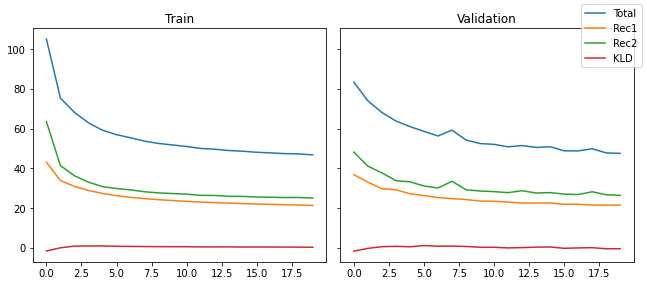

In [15]:
fig, ax = plt.subplots(ncols=2, sharex='all', sharey='all', figsize=(9, 4))

for i, label in enumerate(('Total', 'Rec1', 'Rec2', 'KLD')):
    ax[0].plot(train_loss[i], label=label)
    ax[1].plot(test_loss[i], label=label)
ax[0].set_title('Train')
ax[1].set_title('Validation')
fig.legend(*ax[0].get_legend_handles_labels())
fig.tight_layout()

In [16]:
with torch.no_grad():
    for i, data in enumerate(test_loader):
        results = vae([data[0].to(device, dtype=torch.float32), data[1].to(device, dtype=torch.float32)])
        break

In [17]:
results['x_rec'][0].shape, data[0].shape

(torch.Size([64, 784]), torch.Size([64, 784]))

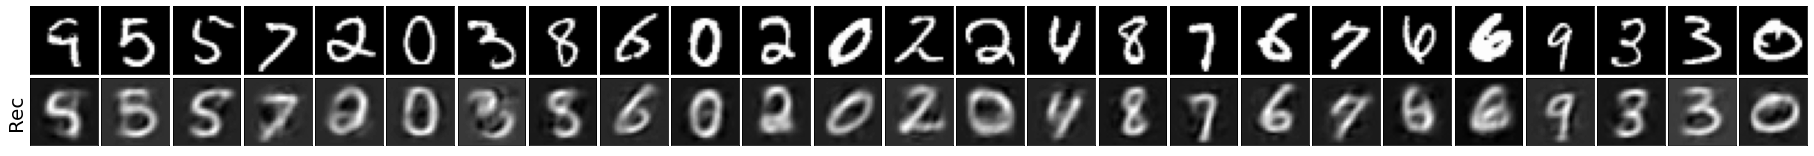

In [18]:
ncols = min(len(results['x_rec'][0]), 25)
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(25, 2))
for i, aux in enumerate(zip(data[0], results['x_rec'][0])):
    if i >= ncols:
        break
    for j, im in enumerate(aux):
        ax[j, i].imshow(im.cpu().numpy().reshape(28, 28), cmap='gray')
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
ax[1, 0].set_ylabel('Rec', fontsize=20)
fig.tight_layout(pad=0)

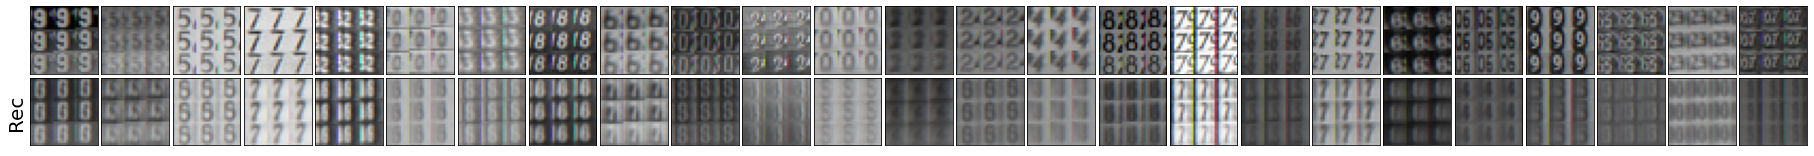

In [19]:
ncols = min(len(results['x_rec'][1]), 25)
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(25, 2))
for i, aux in enumerate(zip(data[1], results['x_rec'][1])):
    if i >= ncols:
        break
    for j, im in enumerate(aux):
        ax[j, i].imshow(im.cpu().numpy().reshape(32, 32, 3))
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
ax[1, 0].set_ylabel('Rec', fontsize=20)
fig.tight_layout(pad=0)